# The risk of diabetes increases with age

H0. no difference regardless of age\
H1. difference in the outcome as the age increases

In [1]:
## logistic regression
## risk of diabetes (outcome) --> categorical (binominal)
## age --> numeric (1,2,3..)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import stan
import csv

In [3]:
import nest_asyncio #this library is important to use pystan

nest_asyncio.apply()

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
import scipy.stats as stats

In [135]:
## evaluation model
import scipy
from sklearn.metrics import classification_report

In [6]:
## import data

df = pd.read_csv('../db/diabetes.csv')

In [7]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [8]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/ipykernel_72321/3306392025.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.Age,color='r')


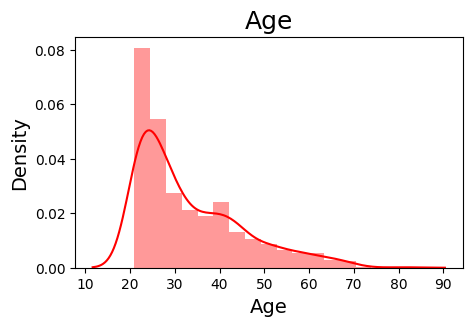

In [9]:
plt.figure(figsize=(5,3))
sns.distplot(df.Age,color='r')
plt.title('Age',size=18)
plt.xlabel('Age',size=14)
plt.ylabel('Density',size=14)
plt.show()

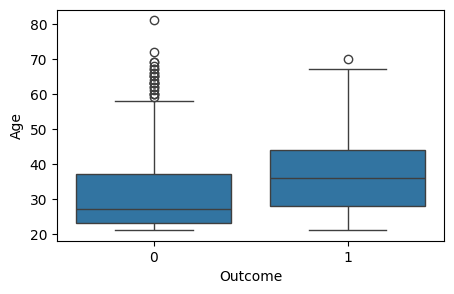

In [10]:
fig, (ax1) = plt.subplots(1, 1, figsize=(5, 3))
sns.boxplot(data=df, ax = ax1, x='Outcome', y='Age')
plt.show()

In [11]:
train, test = train_test_split(df, test_size=0.3)

In [12]:
## train

train_data = {
"N": len(train), 
"ages": train.loc[:, "Age"].values,
 "y": train.loc[:, "Outcome"].values,   
}

In [13]:
## normal distribution
## default flat prior

stan_prior = """

data {
int<lower=0> N;
int<lower = 0, upper = 1> y[N];
vector[N] ages;
}


parameters {

//declare parameters that will be estimated
real alpha;
real beta_age;
}

model {
// Declare your probability model: priors, hyperpriors & likelihood

///prior 

vector[N] p;
p = ages * beta_age + alpha;

}

"""

In [14]:
stan_prior_model = stan.build(stan_prior, data=train_data)

Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_vxd5q0gd/model_w6n2z5tm.stan', line 5, column 0: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
    calculation.
    calculation.


In [15]:
fit_prior = stan_prior_model.fixed_param(num_chains=1, num_samples=1000) 
## posterior: Stan generates samples from the joint posterior distribution of the parameters

Sampling:   0%
Sampling: 100% (1000/1000)
Sampling: 100% (1000/1000), done.


In [16]:
## normal distribution
## default flat prior

stan_code = """

data {
int<lower=0> N;
int<lower = 0, upper = 1> y[N];
vector[N] ages;
}


parameters {

//declare parameters that will be estimated
real alpha;
real beta_age;
}

model {
// Declare your probability model: priors, hyperpriors & likelihood

///prior 

vector[N] p;
p = ages * beta_age + alpha;

//likelihood
y ~ bernoulli_logit(p);
}

generated quantities {
//predictive posterior check

real y_rep[N];

for(n in 1:N){
y_rep[n] = inv_logit(ages[n] * beta_age + alpha);

}
}
"""

In [17]:
stan_model = stan.build(stan_code, data=train_data)

Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_bunfnv2p/model_dofpq7vc.stan', line 5, column 0: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_bunfnv2p/model_dofpq7vc.stan', line 32, column 0: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positi

In [18]:
fit = stan_model.sample(num_chains=4, num_samples=1000, num_warmup=500) 
## posterior: Stan generates samples from the joint posterior distribution of the parameters

Sampling:   0%
Sampling:   0% (1/6000)
Sampling:   3% (201/6000)
Sampling:  28% (1701/6000)
Sampling:  53% (3201/6000)
Sampling:  78% (4700/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.001875 seconds
  1000 transitions using 10 leapfrog steps per transition would take 18.75 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.001525 seconds
  1000 transitions using 10 leapfrog steps per transition would take 15.25 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.001336 seconds
  1000 transitions using 10 leapfrog steps per transition would take 13.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.001434 seconds
  1000 transitions using 10 leapfrog steps per transition would take 14.34 seconds.
  Adjust your expectations accordingly!


In [19]:
fit.to_frame()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta_age,y_rep.1,...,y_rep.528,y_rep.529,y_rep.530,y_rep.531,y_rep.532,y_rep.533,y_rep.534,y_rep.535,y_rep.536,y_rep.537
draws,,,,,,,,,,,,,,,,,,,,,
0,-332.215541,0.998062,0.254997,3.0,15.0,0.0,332.596879,-1.875959,0.034904,0.407317,...,0.476060,0.275191,0.311327,0.261487,0.326488,0.342020,0.326488,0.268284,0.303893,0.349918
1,-332.723397,0.981413,0.213445,3.0,11.0,0.0,332.966030,-1.603078,0.029766,0.419913,...,0.478763,0.303824,0.336189,0.291381,0.349601,0.363256,0.349601,0.297565,0.329579,0.370169
2,-332.784460,0.887190,0.274867,2.0,3.0,0.0,333.072689,-1.932267,0.033825,0.382775,...,0.448388,0.258685,0.292414,0.245925,0.306605,0.321173,0.306605,0.252252,0.285465,0.328591
3,-332.476437,0.994584,0.207883,4.0,19.0,0.0,332.544623,-1.662452,0.030883,0.417153,...,0.478163,0.297447,0.330689,0.284703,0.344500,0.358579,0.344500,0.291033,0.323890,0.365713
4,-334.733163,0.910955,0.254997,3.0,11.0,0.0,337.251623,-1.231243,0.020236,0.410696,...,0.450364,0.330682,0.353447,0.321786,0.362750,0.372156,0.362750,0.326218,0.348836,0.376897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-334.224611,0.960312,0.207883,4.0,17.0,0.0,334.616458,-1.581484,0.022490,0.351053,...,0.393054,0.269582,0.292289,0.260818,0.301680,0.311239,0.301680,0.265177,0.287659,0.316081
3996,-333.773974,1.000000,0.254997,1.0,1.0,0.0,333.976884,-2.202142,0.040643,0.388296,...,0.467711,0.241327,0.280456,0.226759,0.297148,0.314400,0.297148,0.233964,0.272328,0.323226
3997,-333.842737,0.992353,0.213445,2.0,3.0,0.0,333.845785,-2.308742,0.046029,0.418360,...,0.509679,0.247499,0.292794,0.230755,0.312213,0.332314,0.312213,0.239026,0.283355,0.342604


In [20]:
summary1 = az.summary(fit) #https://python.arviz.org/en/stable/getting_started/Introduction.html

In [21]:
summary1

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-1.815,0.282,-2.323,-1.291,0.010,0.007,831.0,878.0,1.01
beta_age,0.033,0.008,0.018,0.047,0.000,0.000,855.0,915.0,1.01
y_rep[0],0.406,0.029,0.355,0.461,0.001,0.000,2434.0,2452.0,1.00
y_rep[1],0.248,0.026,0.199,0.294,0.001,0.001,1033.0,1336.0,1.01
y_rep[2],0.569,0.060,0.455,0.677,0.002,0.001,1118.0,1520.0,1.01
...,...,...,...,...,...,...,...,...,...
y_rep[532],0.343,0.022,0.305,0.385,0.000,0.000,4038.0,2801.0,1.00
y_rep[533],0.329,0.021,0.291,0.369,0.000,0.000,3281.0,2744.0,1.00
y_rep[534],0.273,0.023,0.231,0.318,0.001,0.000,1241.0,1858.0,1.01
y_rep[535],0.307,0.021,0.269,0.348,0.000,0.000,1942.0,2293.0,1.00


In [22]:
stan_data_simu_v1 = az.from_pystan(
    posterior=fit,
    posterior_predictive=["y_rep"],
    observed_data=["y"],
    posterior_model=stan_model,
    coords={"y_rep": np.arange(train_data["N"])},
    prior = fit_prior
)

In [23]:
stan_data_simu_v1

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> sample_stats_prior
	> observed_data

The reference value is outside of the posterior. This translate into infinite support for H1, which is most likely an overstatement.
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/arviz/stats/density_utils.py:720: RuntimeWarning: divide by zero encountered in divide
  pdf /= bw * (2 * np.pi) ** 0.5
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/arviz/stats/density_utils.py:720: RuntimeWarning: invalid value encountered in divide
  pdf /= bw * (2 * np.pi) ** 0.5
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
The reference value is outside of the posterior. This translate into infinite support for H1, which is most likely an overstatement.


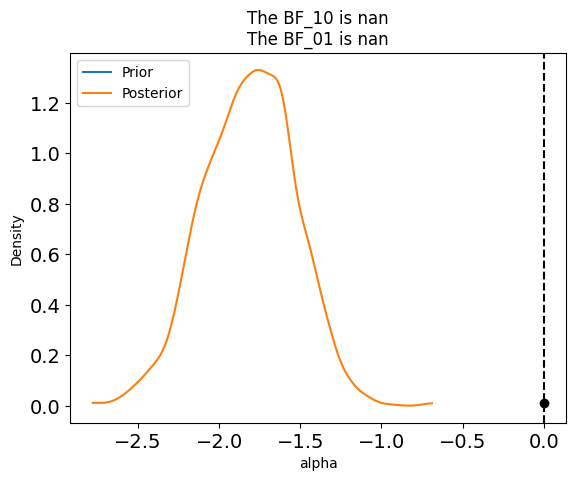

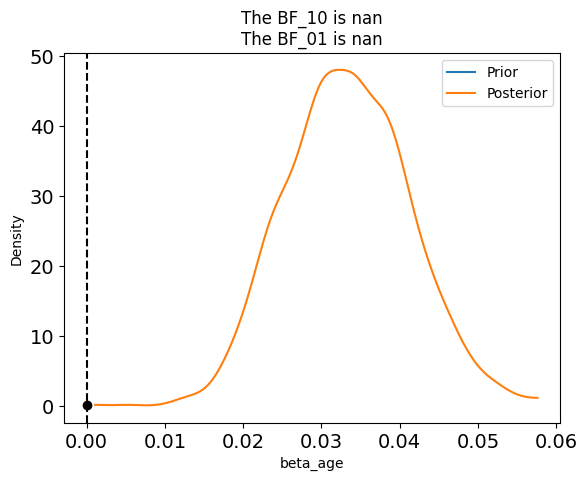

In [24]:
idata = stan_data_simu_v1

az.plot_bf(idata, var_name="alpha", ref_val=0)
az.plot_bf(idata, var_name="beta_age", ref_val=0)

plt.show()


In [25]:
## normal distribution
## default flat prior

stan_code_v2 = """

data {
int<lower=0> N;
int<lower = 0, upper = 1> y[N];
vector[N] ages;
}


parameters {

//declare parameters that will be estimated
real alpha;
real beta_age;
}

model {
// Declare your probability model: priors, hyperpriors & likelihood

///prior 

vector[N] p;
alpha ~ normal(-2,1);
beta_age ~ normal(0.045,1);

p = ages * beta_age + alpha;

//likelihood
y ~ bernoulli_logit(p);
}

generated quantities {
//predictive posterior check

array[N] int y_rep;

for(n in 1:N){
y_rep[n] = bernoulli_logit_rng(ages[n] * beta_age + alpha);

}
}
"""

In [26]:
## normal distribution
## default flat prior

stan_code_prior_v2 = """

data {
int<lower=0> N;
int<lower = 0, upper = 1> y[N];
vector[N] ages;
}


parameters {

//declare parameters that will be estimated
real alpha;
real beta_age;
}

model {
// Declare your probability model: priors, hyperpriors & likelihood

///prior 

vector[N] p;
alpha ~ normal(-2,1);
beta_age ~ normal(0.045,1);

}
"""

In [27]:
data = {
"N": len(df), 
"ages": df.loc[:, "Age"].values,
"y": df.loc[:, "DiabetesPedigreeFunction"].values,
}

In [28]:
stan_model_v2 = stan.build(stan_code_v2, data=train_data)

Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_6nfzrl43/model_ukbiipjo.stan', line 5, column 0: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_6nfzrl43/model_ukbiipjo.stan', line 24, column 18: Argument
    0.045 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).


In [29]:
stan_model_prior_v2 = stan.build(stan_code_prior_v2, data=train_data)

Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_l79fjoax/model_ixav4s5c.stan', line 5, column 0: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_l79fjoax/model_ixav4s5c.stan', line 24, column 18: Argument
    0.045 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).


In [30]:
fit_v2_prior = stan_model_prior_v2.sample(num_chains=4, num_samples=1000) 
## posterior: Stan generates samples from the joint posterior distribution of the parameters

Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.001037 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.37 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000836 seconds
  1000 transitions using 10 leapfrog steps per transition would take 8.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000686 seconds
  1000 transitions using 10 leapfrog steps per transition would take 6.86 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000699 seconds
  1000 transitions using 10 leapfrog steps per transition would take 6.99 seconds.
  Adjust your expectations accordingly!


In [31]:
fit_v2 = stan_model_v2.sample(num_chains=4, num_samples=1000, num_warmup=500) 
## posterior: Stan generates samples from the joint posterior distribution of the parameters

Sampling:   0%
Sampling:   0% (1/6000)
Sampling:  25% (1501/6000)
Sampling:  50% (3001/6000)
Sampling:  75% (4501/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.00162 seconds
  1000 transitions using 10 leapfrog steps per transition would take 16.2 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.001379 seconds
  1000 transitions using 10 leapfrog steps per transition would take 13.79 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.001384 seconds
  1000 transitions using 10 leapfrog steps per transition would take 13.84 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00136 seconds
  1000 transitions using 10 leapfrog steps per transition would take 13.6 seconds.
  Adjust your expectations accordingly!


each sample of that parameter (so the sampling method has generated 1000 values for each parameter)

In [32]:
fit_v2.to_frame()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta_age,y_rep.1,...,y_rep.528,y_rep.529,y_rep.530,y_rep.531,y_rep.532,y_rep.533,y_rep.534,y_rep.535,y_rep.536,y_rep.537
draws,,,,,,,,,,,,,,,,,,,,,
0,-334.214847,0.906623,0.235520,2.0,3.0,0.0,334.774828,-2.341194,0.045819,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,-333.485771,0.826627,0.254143,2.0,3.0,0.0,334.014769,-1.610457,0.031628,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
2,-332.209147,1.000000,0.238686,2.0,3.0,0.0,333.684198,-1.819387,0.033873,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,-332.466777,0.999469,0.233902,3.0,15.0,0.0,332.671768,-2.008441,0.038659,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-334.053661,0.977376,0.235520,2.0,3.0,0.0,334.467213,-2.319045,0.047560,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-332.371141,0.989647,0.233902,1.0,3.0,0.0,334.056139,-1.919498,0.037207,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3996,-332.333860,0.991874,0.235520,4.0,19.0,0.0,333.057256,-1.895742,0.036553,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
3997,-332.474183,0.968628,0.254143,1.0,1.0,0.0,332.494361,-1.742948,0.033264,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
beta_age_m = fit_v2['beta_age'].mean()

In [34]:
beta_age_m

0.03396768834951032

In [35]:
summary2 = az.summary(fit_v2) #https://python.arviz.org/en/stable/getting_started/Introduction.html

/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


In [36]:
summary2

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-1.840,0.257,-2.301,-1.341,0.009,0.006,893.0,1130.0,1.0
beta_age,0.034,0.007,0.020,0.047,0.000,0.000,868.0,978.0,1.0
y_rep[0],0.402,0.490,0.000,1.000,0.008,0.006,3947.0,3947.0,1.0
y_rep[1],0.242,0.428,0.000,1.000,0.007,0.005,4245.0,4000.0,1.0
y_rep[2],0.572,0.495,0.000,1.000,0.008,0.006,3852.0,3852.0,1.0
...,...,...,...,...,...,...,...,...,...
y_rep[532],0.348,0.477,0.000,1.000,0.007,0.005,4222.0,4000.0,1.0
y_rep[533],0.326,0.469,0.000,1.000,0.007,0.005,4018.0,4000.0,1.0
y_rep[534],0.275,0.447,0.000,1.000,0.007,0.005,4117.0,4000.0,1.0
y_rep[535],0.304,0.460,0.000,1.000,0.007,0.005,4085.0,4000.0,1.0


In [37]:
stan_data_simu_v2 = az.from_pystan(
    posterior=fit_v2,
    posterior_predictive=["y_rep"],
    observed_data=["y"],
    posterior_model=stan_model_v2,
    coords={"y_rep": np.arange(train_data["N"])},
    prior = fit_v2_prior
)

In [38]:
stan_data_simu_v2

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> sample_stats_prior
	> observed_data

<Axes: xlabel='y / y_rep'>

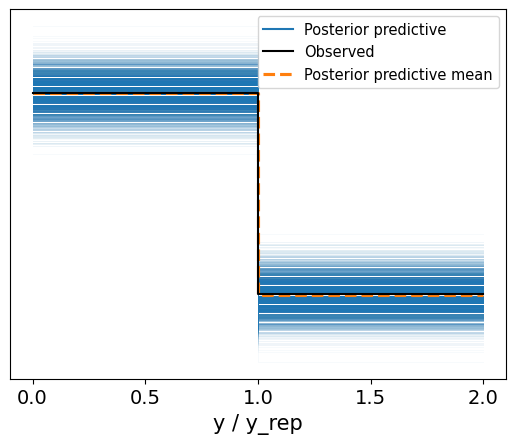

In [39]:
az.plot_ppc(stan_data_simu_v2, data_pairs={"y": "y_rep"}, alpha=0.03, textsize=14)

The reference value is outside of the posterior. This translate into infinite support for H1, which is most likely an overstatement.


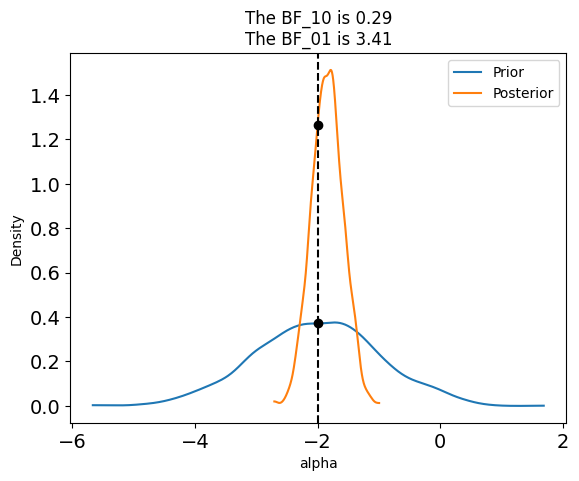

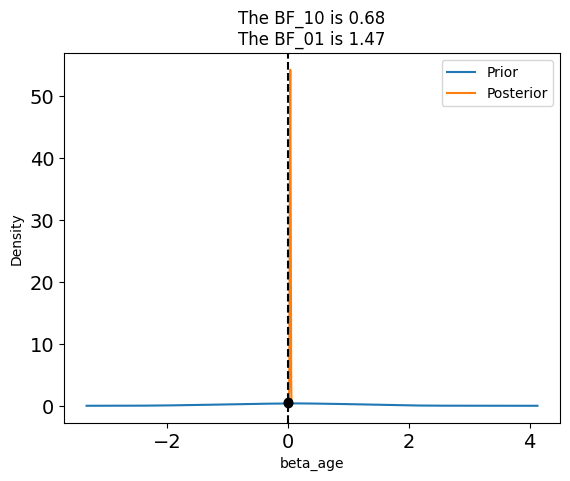

In [59]:
idata_v2 = stan_data_simu_v2

az.plot_bf(idata_v2, var_name="alpha", ref_val=-2)
az.plot_bf(idata_v2, var_name="beta_age", ref_val=0)

plt.show()


In [45]:
## normal distribution
## default flat prior

stan_code_v3 = """

data {
int<lower=0> N;
int<lower = 0, upper = 1> y[N];
vector[N] ages;
}


parameters {

//declare parameters that will be estimated
real alpha;
real beta_age;
}

model {
// Declare your probability model: priors, hyperpriors & likelihood

///prior 

vector[N] p;
alpha ~ normal(-2,1);
beta_age ~ normal(0.045,0.008);

p = ages * beta_age + alpha;

//likelihood
y ~ bernoulli_logit(p);
}

generated quantities {
//predictive posterior check

array[N] int y_rep;

for(n in 1:N){
y_rep[n] = bernoulli_logit_rng(ages[n] * beta_age + alpha);

}
}
"""

In [46]:
## normal distribution
## default flat prior

stan_code_prior_v3 = """

data {
int<lower=0> N;
int<lower = 0, upper = 1> y[N];
vector[N] ages;
}


parameters {

//declare parameters that will be estimated
real alpha;
real beta_age;

}


model {
// Declare your probability model: priors, hyperpriors & likelihood

///prior 

alpha ~ normal(-2,1);
beta_age ~ normal(0.045,0.008);
vector[N] p;
p = ages * beta_age + alpha;
}

"""

In [48]:
stan_model_v3 = stan.build(stan_code_v3, data=train_data)

Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_qvvmeg05/model_lbjzhf3t.stan', line 5, column 0: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_qvvmeg05/model_lbjzhf3t.stan', line 24, column 24: Argument
    0.008 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_qvvmeg05/model_lbjzhf3t.stan', line 24, column 18: Argument
    0.045 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).


In [49]:
stan_model_prior_v3 = stan.build(stan_code_prior_v3, data=train_data)

Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_1eyxwfs8/model_nwkw2flz.stan', line 5, column 0: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_1eyxwfs8/model_nwkw2flz.stan', line 25, column 24: Argument
    0.008 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_1eyxwfs8/model_nwkw2flz.stan', line 25, column 18: Argument
    0.045 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).


In [50]:
fit_v3_prior = stan_model_prior_v3.sample(num_chains=4, num_samples=1000) 
## posterior: Stan generates samples from the joint posterior distribution of the parameters

Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.00157 seconds
  1000 transitions using 10 leapfrog steps per transition would take 15.7 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.001057 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.57 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000916 seconds
  1000 transitions using 10 leapfrog steps per transition would take 9.16 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00092 seconds
  1000 transitions using 10 leapfrog steps per transition would take 9.2 seconds.
  Adjust your expectations accordingly!


In [51]:
fit_v3 = stan_model_v3.sample(num_chains=4, num_samples=1000) 
## posterior: Stan generates samples from the joint posterior distribution of the parameters

Sampling:   0%
Sampling:   4% (300/8000)
Sampling:  10% (800/8000)
Sampling:  35% (2800/8000)
Sampling:  60% (4800/8000)
Sampling:  81% (6500/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.001516 seconds
  1000 transitions using 10 leapfrog steps per transition would take 15.16 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.001445 seconds
  1000 transitions using 10 leapfrog steps per transition would take 14.45 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00149 seconds
  1000 transitions using 10 leapfrog steps per transition would take 14.9 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.001433 seconds
  1000 transitions using 10 leapfrog steps per transition would take 14.33 seconds.
  Adjust your expectations accordingly!


In [52]:
fit_v3.to_frame()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta_age,y_rep.1,...,y_rep.528,y_rep.529,y_rep.530,y_rep.531,y_rep.532,y_rep.533,y_rep.534,y_rep.535,y_rep.536,y_rep.537
draws,,,,,,,,,,,,,,,,,,,,,
0,-332.783119,0.999671,0.349155,3.0,11.0,0.0,333.158306,-2.002598,0.039274,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
1,-332.953939,0.990796,0.322766,3.0,15.0,0.0,335.718615,-1.871559,0.035931,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2,-332.821179,0.846584,0.250945,3.0,11.0,0.0,334.230335,-1.929731,0.037168,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,-332.963926,0.987935,0.281256,2.0,3.0,0.0,333.631886,-2.119085,0.042087,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
4,-332.817043,0.997424,0.349155,4.0,15.0,0.0,332.840451,-2.047362,0.040382,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-334.158300,1.000000,0.281256,1.0,1.0,0.0,334.409023,-2.295756,0.047829,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3996,-333.138026,0.977313,0.349155,3.0,11.0,0.0,333.536812,-1.881434,0.037622,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
3997,-334.087495,0.976952,0.322766,3.0,7.0,0.0,334.208192,-2.290659,0.047599,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [53]:
summary3 = az.summary(fit_v3) #https://python.arviz.org/en/stable/getting_started/Introduction.html

In [54]:
summary3

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-2.008,0.210,-2.397,-1.612,0.007,0.005,825.0,912.0,1.01
beta_age,0.039,0.006,0.028,0.049,0.000,0.000,812.0,940.0,1.01
y_rep[0],0.406,0.491,0.000,1.000,0.008,0.006,3917.0,3917.0,1.00
y_rep[1],0.227,0.419,0.000,1.000,0.007,0.005,3961.0,3961.0,1.00
y_rep[2],0.602,0.489,0.000,1.000,0.008,0.006,3949.0,3949.0,1.00
...,...,...,...,...,...,...,...,...,...
y_rep[532],0.352,0.478,0.000,1.000,0.007,0.005,4248.0,4000.0,1.00
y_rep[533],0.324,0.468,0.000,1.000,0.007,0.005,3932.0,3932.0,1.00
y_rep[534],0.255,0.436,0.000,1.000,0.007,0.005,4115.0,4000.0,1.00
y_rep[535],0.297,0.457,0.000,1.000,0.008,0.006,3445.0,3445.0,1.00


In [55]:
stan_data_simu_v3 = az.from_pystan(
    posterior=fit_v3,
    posterior_predictive=["y_rep"],
    observed_data=["y"],
    posterior_model=stan_model_v3,
    coords={"y_rep": np.arange(train_data["N"])},
    prior = fit_v2
)

In [56]:
stan_data_simu_v3

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> sample_stats_prior
	> observed_data

<Axes: xlabel='y / y_rep'>

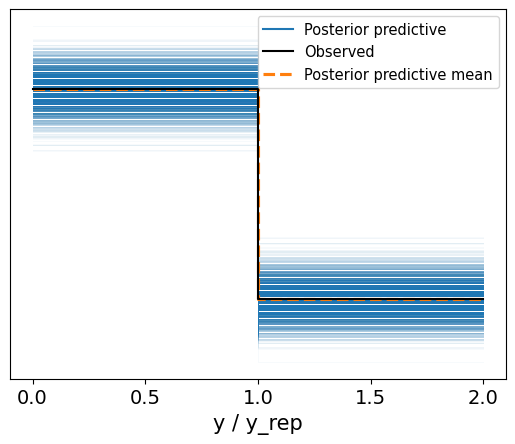

In [57]:
az.plot_ppc(stan_data_simu_v3, data_pairs={"y": "y_rep"}, alpha=0.03, textsize=14)

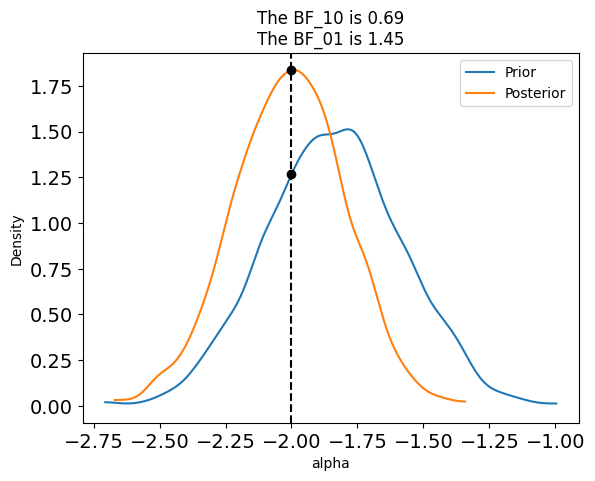

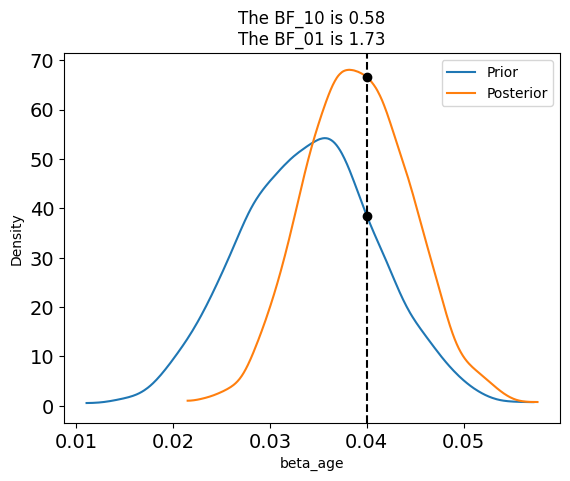

In [58]:
idata_v3 = stan_data_simu_v3

az.plot_bf(idata_v3, var_name="alpha", ref_val=-2)
az.plot_bf(idata_v3, var_name="beta_age", ref_val=0.04)

plt.show()


### Prediction test

In [102]:
## normal distribution
## default flat prior

stan_code_test = """

data {
int<lower=0> N; // the number of training observations
int<lower=0> N2; // the number of test observations

int<lower = 0, upper = 1> y[N];

vector[N] ages;
vector[N2] ages2; //test values
}


parameters {

//declare parameters that will be estimated
real alpha;
real beta_age;
}

model {
// Declare your probability model: priors, hyperpriors & likelihood

///prior 

vector[N] p;
alpha ~ normal(-2,1);
beta_age ~ normal(0.045,0.008);

p = ages * beta_age + alpha;

//likelihood
y ~ bernoulli_logit(p);
}

generated quantities {
//predictive posterior check

array[N] int y_rep;
array[N2] int y_new;
vector[N2] beta_ages_new = ages2 * beta_age;

for(n in 1:N){
y_rep[n] = bernoulli_logit_rng(ages[n] * beta_age + alpha);
}

//test
for(n2 in 1:N2){
 y_new[n2] = bernoulli_logit_rng(beta_ages_new[n2] + alpha);
}
}
"""

In [103]:
## test

test_data = {
"N": len(train), 
"N2": len(test),
"ages": train.loc[:, "Age"].values,
"ages2": test.loc[:, "Age"].values,
 "y": train.loc[:, "Outcome"].values 
}

In [104]:
stan_model_test = stan.build(stan_code_test, data=test_data)

Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/juscbt7c/model_juscbt7c.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/chainable_object.hpp:6:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/typedefs.hpp:7:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-pac

Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/juscbt7c/model_juscbt7c.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:26:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:70:32: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
                           [a, b, digamma_ab](auto& vi) mutable {
                             ~~^


Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/juscbt7c/model_juscbt7c.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/

Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/juscbt7c/model_juscbt7c.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:198:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor.hpp:12:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/hcubature.hpp:468:7: warning: unused variable 'kdiv' [-Wunused-variable]
  int kdiv = kdivide;
      ^


Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/juscbt7c/model_juscbt7c.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:198:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor.hpp:15:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/integrate_ode_rk45.hpp:6:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-

Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/juscbt7c/model_juscbt7c.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:128:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/gaussian_dlm_obs_rng.hpp:98:7: warning: unused variable 'n' [-Wunused-variable]
  int n = G.rows();  // number of states
      ^


Building: 5.7s
Building: 5.9s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/juscbt7c/model_juscbt7c.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:210:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/multi_student_t_log.hpp:5:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan

Building: 6.0s
Building: 6.1s
Building: 6.2s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/juscbt7c/model_juscbt7c.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:312:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/skew_double_exponential_ccdf_log.hpp:5:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan

Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/juscbt7c/model_juscbt7c.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/

Building: 6.9s
Building: 7.0s
Building: 7.1s
Building: 7.2s


/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:192:12: warning: unused variable 'pre_mult' [-Wunused-variable]
      auto pre_mult = a2 * pow(1 - z, -1 - a2);
           ^
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:307:20: note: in instantiation of function template specialization 'stan::math::internal::grad_2F1_impl<true, true, true, true, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, std::tuple<stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>>>' requested here
  return internal::grad_2F1_impl<true, true, true, true>(a1, a2, b1, z,
                   ^
In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/juscbt7c/model_juscbt7c.cpp:2:
In file i

Building: 7.3s
Building: 7.4s
Building: 7.5s
Building: 7.6s
Building: 7.7s
Building: 7.8s
Building: 7.9s
Building: 8.0s
Building: 8.1s
Building: 8.2s
Building: 8.3s
Building: 8.4s
Building: 8.5s
Building: 8.6s
Building: 8.7s
Building: 8.8s
Building: 8.9s
Building: 9.0s
Building: 9.1s
Building: 9.2s
Building: 9.3s
Building: 9.4s
Building: 9.5s
Building: 9.6s
Building: 9.8s
Building: 9.9s
Building: 10.0s
Building: 10.1s
Building: 10.2s
Building: 10.3s
Building: 10.4s
Building: 10.5s
Building: 10.6s
Building: 10.7s
Building: 10.8s
Building: 10.9s
Building: 11.0s
Building: 11.1s
Building: 11.2s
Building: 11.3s


21 warnings generated.
ld: warning: object file (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/stan_services.o) was built for newer macOS version (11.0) than being linked (10.9)
ld: warning: dylib (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libtbb.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: dylib (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libtbbmalloc.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: object file (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libsundials_nvecserial.a(nvector_serial.o)) was built for newer macOS version (11.0) than being linked (10.9)
ld: warning: object file (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libsundials_cvodes.a(cvodea.o)) was built for newer macOS version (11.0) than being linked (10.9)
ld: 

Building: 11.4s, done.
Messages from stanc:
Warning in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_asqhoafw/model_juscbt7c.stan', line 7, column 0: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_asqhoafw/model_juscbt7c.stan', line 28, column 24: Argument
    0.008 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_asqhoafw/model_juscbt7c.stan', line 28, column 18: Argument
    0.045 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).


In [105]:
fit_test = stan_model_test.sample(num_chains=4, num_samples=1000) 
## posterior: Stan generates samples from the joint posterior distribution of the parameters

Sampling:   0%
Sampling:   4% (300/8000)
Sampling:  29% (2300/8000)
Sampling:  54% (4300/8000)
Sampling:  79% (6300/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.001577 seconds
  1000 transitions using 10 leapfrog steps per transition would take 15.77 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.001663 seconds
  1000 transitions using 10 leapfrog steps per transition would take 16.63 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.001495 seconds
  1000 transitions using 10 leapfrog steps per transition would take 14.95 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.001443 seconds
  1000 transitions using 10 leapfrog steps per transition would take 14.43 seconds.
  Adjust your expectations accordingly!


In [108]:
fit_test.to_frame()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta_age,y_rep.1,...,beta_ages_new.222,beta_ages_new.223,beta_ages_new.224,beta_ages_new.225,beta_ages_new.226,beta_ages_new.227,beta_ages_new.228,beta_ages_new.229,beta_ages_new.230,beta_ages_new.231
draws,,,,,,,,,,,,,,,,,,,,,
0,-332.783119,0.999671,0.349155,3.0,11.0,0.0,333.158306,-2.002598,0.039274,0.0,...,1.413871,1.021129,2.277903,1.099677,0.824758,1.767339,1.060403,1.492419,0.942581,0.824758
1,-332.953939,0.990796,0.322766,3.0,15.0,0.0,335.718615,-1.871559,0.035931,0.0,...,1.293504,0.934197,2.083978,1.006058,0.754544,1.616879,0.970128,1.365365,0.862336,0.754544
2,-332.821179,0.846584,0.250945,3.0,11.0,0.0,334.230335,-1.929731,0.037168,0.0,...,1.338061,0.966377,2.155764,1.040714,0.780535,1.672576,1.003545,1.412397,0.892040,0.780535
3,-332.963926,0.987935,0.281256,2.0,3.0,0.0,333.631886,-2.119085,0.042087,0.0,...,1.515124,1.094256,2.441033,1.178430,0.883822,1.893905,1.136343,1.599297,1.010083,0.883822
4,-333.060097,0.963022,0.349155,3.0,15.0,0.0,333.826523,-2.044031,0.041639,1.0,...,1.498994,1.082607,2.415046,1.165884,0.874413,1.873743,1.124246,1.582272,0.999329,0.874413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-332.820997,1.000000,0.281256,2.0,3.0,0.0,332.868754,-2.023432,0.038634,0.0,...,1.390810,1.004474,2.240749,1.081741,0.811306,1.738512,1.043107,1.468077,0.927206,0.811306
3996,-334.076636,0.905456,0.349155,1.0,3.0,0.0,334.766601,-2.284185,0.043385,1.0,...,1.561850,1.128002,2.516313,1.214772,0.911079,1.952312,1.171387,1.648619,1.041233,0.911079
3997,-333.349101,0.999782,0.322766,3.0,11.0,0.0,334.027930,-2.145773,0.044213,1.0,...,1.591669,1.149539,2.564356,1.237965,0.928474,1.989586,1.193752,1.680095,1.061113,0.928474


In [109]:
summary_test = az.summary(fit_test) #https://python.arviz.org/en/stable/getting_started/Introduction.html

In [113]:
summary_test

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-1.996,0.209,-2.403,-1.620,0.008,0.006,668.0,1228.0,1.0
beta_age,0.039,0.005,0.029,0.049,0.000,0.000,818.0,1164.0,1.0
y_rep[0],0.409,0.492,0.000,1.000,0.008,0.005,4000.0,4000.0,1.0
y_rep[1],0.238,0.426,0.000,1.000,0.007,0.005,4060.0,4000.0,1.0
y_rep[2],0.602,0.490,0.000,1.000,0.008,0.005,4177.0,4000.0,1.0
y_rep[3],0.296,0.456,0.000,1.000,0.007,0.005,3993.0,3993.0,1.0
y_rep[4],0.332,0.471,0.000,1.000,0.008,0.005,3784.0,3784.0,1.0
y_rep[5],0.298,0.457,0.000,1.000,0.007,0.005,3932.0,3932.0,1.0
y_rep[6],0.484,0.500,0.000,1.000,0.008,0.006,3894.0,3894.0,1.0
y_rep[7],0.402,0.490,0.000,1.000,0.008,0.006,3823.0,3823.0,1.0


In [125]:
y_pred = fit_test['y_new']

In [130]:
y_pred = scipy.stats.mode(y_pred, axis=1).mode.ravel()

In [134]:
print(classification_report(test.loc[:, "Outcome"].values, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.93      0.75       142
           1       0.50      0.11      0.18        89

    accuracy                           0.61       231
   macro avg       0.56      0.52      0.47       231
weighted avg       0.58      0.61      0.53       231



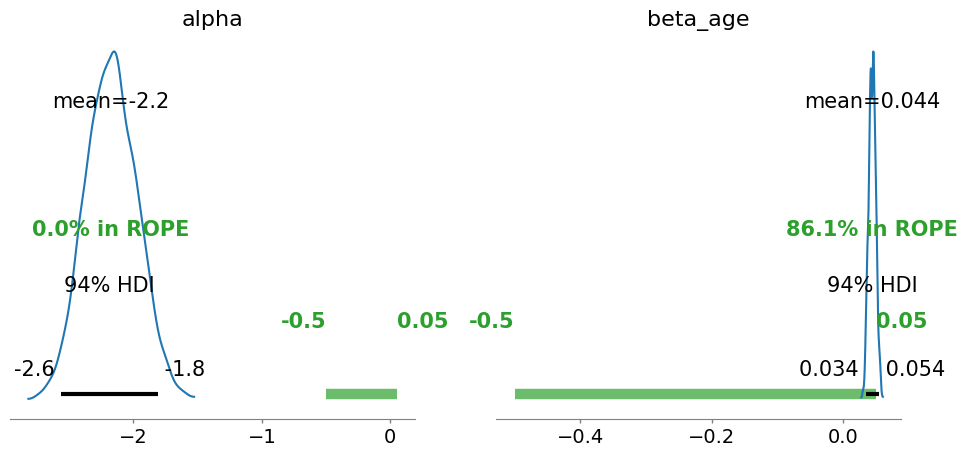

In [457]:
axes = az.plot_posterior(
    stan_data_simu_v3,
    var_names=["alpha", "beta_age"],
    rope=(-0.5, 0.05),
    figsize=(11.5, 5),
)

The probability of age increases the risk of diabetes is 0.001

In [ ]:
## set dataframe display infinite
pd.set_option('display.max_rows', None)  # or 1000

In [367]:
# import the relevant modules
import shutil
import httpstan.models
import httpstan.cache

In [394]:
httpstan.cache.list_model_names()

['models/b7qaijo4',
 'models/3yg3dt7o',
 'models/w3qg742z',
 'models/kx4sr7ls',
 'models/nwkw2flz',
 'models/ucizkawn',
 'models/tnps5wyn']

In [402]:
httpstan.cache.delete_model_directory('models/tnps5wyn') ## add the model pointer you want to remove